This notebook is a loose re-implementation of some of the work listed in the paper

In [1]:
# imports
import torch
import numpy
import matplotlib.pyplot as plt
from torchvision import models, datasets, transforms
from sklearn.neighbors import KNeighborsClassifier
import faiss
import tqdm
import numpy as np

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 32

In [3]:
def imshow(inp, title=None,
          mean=numpy.array([0.485, 0.456, 0.406]),
          std=numpy.array([0.229, 0.224, 0.225])):
    """Show torch tensor"""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = std * inp + mean
    inp = numpy.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

Files already downloaded and verified
Files already downloaded and verified


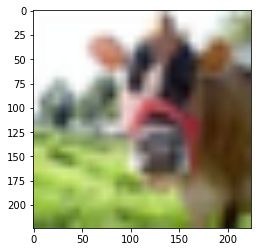

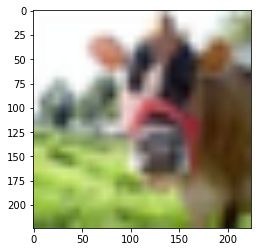

In [5]:
# Get dataset
train_dataset = datasets.CIFAR100('/data/cifar100/', train=True, download=True,
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))

trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
            num_workers=8, shuffle = False)

test_dataset = datasets.CIFAR100('/data/cifar100/', train=False, download=True,
        transform=transforms.Compose([
            transforms.Resize(224),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])
        ]))

testloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
            num_workers=8, shuffle = False)

imshow(train_dataset[0][0])
imshow(next(iter(trainloader))[0][0])

In [6]:
class IntermediateReps(torch.nn.Module):
    
    def __init__(self, model, intermediate_layers):
        super(IntermediateReps, self).__init__()
        self.model = model
        self.intermediate_layers = intermediate_layers
        self._features = {layer: torch.empty(0) for layer in intermediate_layers}
        self.handles = []
        
        for layer_id in self.intermediate_layers:
            layer = dict([*self.model.named_modules()])[layer_id]
            self.handles.append(
                layer.register_forward_hook(self.save_outputs_hook(layer_id))
            )

    def save_outputs_hook(self, layer_id: str):
        def fn(_, __, output):
            self._features[layer_id] = output
        return fn

    def forward(self, x):
        _ = self.model(x)
        return self._features
    
    def remove_handles(self):
        for h in self.handles:
            h.remove()
        self.handles = []

In [7]:
model = IntermediateReps(
    models.resnet18(pretrained=True),
    [
        'bn1',
        'layer1.0.bn1',
        'layer1.0.bn2',
        'layer1.1.bn1',
        'layer1.1.bn2',
        'layer2.0.bn1',
        'layer2.0.bn2',
        'layer2.1.bn1',
        'layer2.1.bn2',
        'layer3.0.bn1',
        'layer3.0.bn2',
        'layer3.1.bn1',
        'layer3.1.bn2',
        'layer4.0.bn1',
        'layer4.0.bn2',
        'layer4.1.bn1',
        'layer4.1.bn2',
        'fc'
    ]
)

In [7]:
import math
dim =  802816#2048
K = int(8*math.sqrt(len(train_dataset)))
M = 128
D = 4 * M
index_factor_str = f'IVF{K},Flat'
index_factor_str = f'OPQ{M}_{D},IVF{K},PQ{M}'
index_factor_str = f"PCA128,Flat"
print(K, index_factor_str)
index = faiss.index_factory(dim,index_factor_str, faiss.METRIC_INNER_PRODUCT)
index.is_trained
index.train(np.random.rand(32,dim).astype(np.float32))

1788 PCA128,Flat


False

In [8]:
import math
import os
model = model.eval().to(device)
with torch.no_grad():
    shape_array = model(torch.rand(1,3,224,224).to(device))
    
K = int(8*math.sqrt(len(train_dataset)))
index_factor_str = f'OPQ128_2048,IVF{K},PQ128'
index_factor_str = f"PCA2048,Flat"
faiss_indices = {
    # can switch to different index for speed
    k :  faiss.IndexIDMap(faiss.IndexFlatL2(int(np.prod(v.shape))))
    #k :  faiss.index_factory(int(np.prod(v.shape)),index_factor_str, faiss.METRIC_INNER_PRODUCT)
    for k,v in shape_array.items()
}

needs_training = False

with torch.no_grad():
    if needs_training:
        train_outputs = {}
        for i,(data, label) in enumerate(tqdm.tqdm(trainloader)):
            data = data.to(device)
            features = model(data)
            for k,v in features.items():
                output = torch.flatten(v, start_dim=1).cpu().numpy()
                if k not in train_outputs:
                    train_outputs[k] = output
                else:
                    train_outputs[k] = np.vstack([train_outputs[k],output])
            if i > 300:
                break
        for k, output in train_outputs.items():
            faiss_indices[k].train(output)
            if not os.path.exists(base_dir + k):
                os.mkdir(base_dir + k)
            faiss.write_index(faiss_indices[k], base_dir + k + "/trained.index")
        # free up ram
        train_outputs = None
        
    base_dir = "/data/benjamin.pikus/example_difficulty/"
    for i,(data, label) in enumerate(tqdm.tqdm(trainloader)):
        data = data.to(device)
        features = model(data)
        for k,v in features.items():
            if i == 0:
                if not os.path.exists(base_dir + k):
                    os.mkdir(base_dir + k)
                faiss.write_index(faiss_indices[k], base_dir + k + "/trained.index")
            output = torch.flatten(v, start_dim=1).cpu().numpy()
            #faiss_indices[k].add(output)
            faiss_indices[k].add_with_ids(output, np.arange(i * BATCH_SIZE, (i + 1) * BATCH_SIZE))
            if i > 0 and i % 100 == 0:
                faiss.write_index(faiss_indices[k], base_dir + k + f"/block_{i}.index")
                faiss_indices[k] = faiss.read_index(base_dir + k + "/trained.index")
    #for k,v in features.items():
    #    faiss.write_index(faiss_indices[k], base_dir + k + f"/computed.index")

100%|█████████▉| 1562/1563 [47:07<00:01,  1.81s/it]  


AssertionError: not same nb of vectors as ids

In [34]:
class ResultHeap:
    """ Combine query results from a sliced dataset (for k-nn search) """

    def __init__(self, nq, k):
        " nq: number of query vectors, k: number of results per query "
        self.I = np.zeros((nq, k), dtype='int64')
        self.D = np.zeros((nq, k), dtype='float32')
        self.nq, self.k = nq, k
        heaps = faiss.float_maxheap_array_t()
        heaps.k = k
        heaps.nh = nq
        heaps.val = faiss.swig_ptr(self.D)
        heaps.ids = faiss.swig_ptr(self.I)
        heaps.heapify()
        self.heaps = heaps

    def add_batch_result(self, D, I, i0):
        assert D.shape == (self.nq, self.k)
        assert I.shape == (self.nq, self.k)
        I += i0
        self.heaps.addn_with_ids(
            self.k, faiss.swig_ptr(D),
            faiss.swig_ptr(I), self.k)

    def finalize(self):
        self.heaps.reorder()

In [60]:
#from faiss import ResultHeap
import glob
idxs = np.random.choice(np.arange(len(test_dataset)),500, replace = False)
x = torch.utils.data.Subset(train_dataset, idxs)
num_to_return = 30

rh = { 
    k : ResultHeap(len(idxs), num_to_return)
    for k,v in shape_array.items()
}

with torch.no_grad():  
    loader = torch.utils.data.DataLoader(x, batch_size=len(idxs),
            num_workers=8, shuffle = False)
    base_dir = "/data/benjamin.pikus/example_difficulty/"
    for i,(data, label) in enumerate(loader):
        data = data.to(device)
        features = model(data)
    
        for k,v in features.items():
            if k == 'bn1':
                continue
            sub_indexes = glob.glob(base_dir + k + '/block*')
            output = torch.flatten(v, start_dim=1).cpu().numpy()
            for s in tqdm.tqdm(sub_indexes):
                index = faiss.read_index(s)
                Di, Ii = index.search(output, num_to_return)
                rh[k].add_batch_result(Di, Ii, 0)
                
for r in rh.values():
    r.finalize()

100%|██████████| 15/15 [00:02<00:00,  6.55it/s]


In [78]:
np.append(np.array([]),label.numpy()).shape

(500,)

In [93]:
y_train = np.array([])
for i,(data, label) in enumerate(tqdm.tqdm(trainloader)):
    y_train = np.append(y_train, label.numpy())

100%|██████████| 1563/1563 [00:14<00:00, 104.83it/s]


In [94]:
y_actual = np.array([])
for i,(data, label) in enumerate(loader):
    y_actual = np.append(y_actual, label.numpy())

In [101]:
from scipy import stats
predictions = {k:[] 
    for k,v in shape_array.items()}
for i in range(len(idxs)):
    for k in shape_array:
        indices = rh[k].I[i]
        votes = y[indices].astype(int)
        predictions[k].append(stats.mode(votes).mode[0])
        #predictions = np.array([np.argmax(np.bincount(i)) for i in votes])

Accuracy at layer bn1: 0.014
Accuracy at layer layer1.0.bn1: 0.146
Accuracy at layer layer1.0.bn2: 0.154
Accuracy at layer layer1.1.bn1: 0.074
Accuracy at layer layer1.1.bn2: 0.054
Accuracy at layer layer2.0.bn1: 0.038
Accuracy at layer layer2.0.bn2: 0.094
Accuracy at layer layer2.1.bn1: 0.038
Accuracy at layer layer2.1.bn2: 0.058
Accuracy at layer layer3.0.bn1: 0.134
Accuracy at layer layer3.0.bn2: 0.206
Accuracy at layer layer3.1.bn1: 0.134
Accuracy at layer layer3.1.bn2: 0.192
Accuracy at layer layer4.0.bn1: 0.146
Accuracy at layer layer4.0.bn2: 0.192
Accuracy at layer layer4.1.bn1: 0.242
Accuracy at layer layer4.1.bn2: 0.502
Accuracy at layer fc: 0.58


Text(0, 0.5, 'kNN Accuracy')

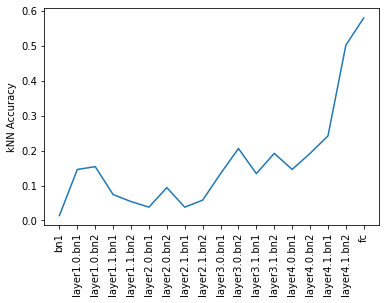

In [109]:
acc = {}
for k in shape_array:
    acc[k] = np.sum(predictions[k] == y_actual) / len(idxs)
    print(f"Accuracy at layer {k}: {acc[k]}")
plt.plot(list(acc.keys()),list(acc.values()))
plt.xticks(rotation = 90) 
plt.ylabel('kNN Accuracy')

In [39]:
# Debug - get shapes
model = model.eval().to(device)
with torch.no_grad():
    shape_array = model(torch.rand(1,3,224,224).to(device))
{
    # can switch to different index for speed
    k : v.shape
    #k :  faiss.index_factory(int(np.prod(v.shape)),index_factor_str, faiss.METRIC_INNER_PRODUCT)
    for k,v in shape_array.items()
}


{'bn1': torch.Size([1, 64, 112, 112]),
 'layer1.0.bn1': torch.Size([1, 64, 56, 56]),
 'layer1.0.bn2': torch.Size([1, 64, 56, 56]),
 'layer1.1.bn1': torch.Size([1, 64, 56, 56]),
 'layer1.1.bn2': torch.Size([1, 64, 56, 56]),
 'layer2.0.bn1': torch.Size([1, 128, 28, 28]),
 'layer2.0.bn2': torch.Size([1, 128, 28, 28]),
 'layer2.1.bn1': torch.Size([1, 128, 28, 28]),
 'layer2.1.bn2': torch.Size([1, 128, 28, 28]),
 'layer3.0.bn1': torch.Size([1, 256, 14, 14]),
 'layer3.0.bn2': torch.Size([1, 256, 14, 14]),
 'layer3.1.bn1': torch.Size([1, 256, 14, 14]),
 'layer3.1.bn2': torch.Size([1, 256, 14, 14]),
 'layer4.0.bn1': torch.Size([1, 512, 7, 7]),
 'layer4.0.bn2': torch.Size([1, 512, 7, 7]),
 'layer4.1.bn1': torch.Size([1, 512, 7, 7]),
 'layer4.1.bn2': torch.Size([1, 512, 7, 7]),
 'avgpool': torch.Size([1, 512, 1, 1]),
 'fc': torch.Size([1, 1000])}

In [ ]:
import faiss

class FaissKNeighbors:
    def __init__(self, k=5):
        self.index = None
        self.y = None
        self.k = k

    def fit(self, X, y):
        self.index = faiss.IndexFlatL2(X.shape[1])
        self.index.add(X.astype(np.float32))
        self.y = y

    def predict(self, X):
        distances, indices = self.index.search(X.astype(np.float32), k=self.k)
        votes = self.y[indices]
        predictions = np.array([np.argmax(np.bincount(x)) for x in votes])
        return predictions